### Преамбула

In [1]:
import os
import sys
import random

In [2]:
import time

In [3]:
import numpy as np

In [4]:
import torch
from torch.utils.data import Dataset

In [5]:
from torch import nn

In [6]:
from torch.nn import functional

In [7]:
import torchvision
import torchvision.transforms as transforms

In [8]:
from torchvision.transforms import InterpolationMode

In [ ]:
from svetlanna import SimulationParameters
from svetlanna.parameters import ConstrainedParameter

In [ ]:
from svetlanna import Wavefront
from svetlanna import elements
from svetlanna.setup import LinearOpticalSetup
from svetlanna.detector import Detector, DetectorProcessorClf

In [11]:
from svetlanna.transforms import ToWavefront

In [ ]:
# датасет волновых фронтов
from src.wf_datasets import DatasetOfWavefronts
from src.wf_datasets import WavefrontsDatasetSimple

In [13]:
from tqdm import tqdm

In [14]:
from datetime import datetime

In [15]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

plt.style.use('dark_background')
%matplotlib inline
# %config InlineBackend.figure_format = 'retina'

# Оптическая нейронная сеть

В этом примере блокнота мы попытаемся реализовать простую архитектуру оптической нейронной сети из статьи [[1]](https://www.science.org/doi/10.1126/science.aat8084), основываяся на следующих утрвеждениях из работы:

> В общем случае фаза и амплитуда каждого нейрона могут быть изучаемыми параметрами, обеспечивая комплекснозначную модуляцию на каждом слое, что улучшает производительность вывода дифракционной сети.

> ... Сначала мы обучили его как классификатор цифр для автоматической классификации рукописных цифр от 0 до 9. Для этой задачи были разработаны маски пропускания, учитывающие только фазу, путём обучения **пятислойной** нейронной сети $D^2 на 55 000 изображений (из них 5000 проверочных) из базы данных рукописных цифр MNIST.

>  Затем мы использовали непрерывное излучение на частоте $0,4$ $ТГц$...

Также из [дополнительных материалов](https://www.science.org/doi/suppl/10.1126/science.aat8084/suppl_file/aat8084-lin-sm-rev-3.pdf) (информация по классификации базы MNIST):

> Поскольку мы рассматриваем когерентное освещение, входная информация может быть закодирована в амплитудных и/или фазовых каналах входной плоскости.

> Для каждого слоя $D^2NN$ мы устанавливаем размер нейрона равным $400$ $\mu m$...

> На плоскости детектор/выход мы измерили интенсивность выхода сети...

#### <span style="color:red">Дополнительная информация/span>

В другой статье [[2]](https://ieeexplore.ieee.org/abstract/document/8732486) тех же авторов были уточнены некоторые детали:

> В нашем численном моделировании мы использовали размер нейрона приблизительно $0,53 \times \lambda $

> Кроме того, высота и ширина каждого дифракционного слоя были заданы так, чтобы включать $200 \times 200 = 40 тыс. нейронов на слой.

# 1. Параметры моделирования

In [16]:
working_frequency = 0.4 * 1e12 # [Hz]
c_const = 299_792_458  # [m / s]

In [17]:
working_wavelength = c_const / working_frequency  # [m]
print(f'lambda = {working_wavelength * 1e6:.3f} um')

lambda = 749.481 um


In [ ]:
# размер нейрона (квадрат)
neuron_size = 0.53 * working_wavelength  # [m]
print(f'neuron size = {neuron_size * 1e6:.3f} um')

neuron size = 397.225 um


In [ ]:
DETECTOR_SIZE = (200, 200)  # размер зоны детектора в которой будут обновляться веса в ходе обучения

**<span style="color:red">Комментарий</span>**

В статьях [1, 2] размер слоя составлял $200x200$ нейронов. Авторы использовали _уравнение Рэлея-Зомерфельда_ для распространения волновых фронтов (см. Методы B)!

Поскольку мы будем использовать метод `AS` для `FreeSpace`, мы увеличиваем размер слоя в `SimulationParameters` (т.е. числовой сетке) в два раза ($400x400$). Но мы добавим **квадратные апертуры** размером $200x200$ нейронов перед каждым `DiffractiveLayer` (только фазовым) и перед `Detector` (последним слоем установки).

In [ ]:
# число нейронов
x_layer_nodes = DETECTOR_SIZE[1] * 2
y_layer_nodes = DETECTOR_SIZE[0] * 2
# Комментарий: в два раза больше, поскольку мы используем апертуры и другой пропагатор по сравнению со статьей

print(f'Layer size (in neurons): {x_layer_nodes} x {y_layer_nodes} = {x_layer_nodes * y_layer_nodes}')

Layer size (in neurons): 400 x 400 = 160000


In [ ]:
# физический размер каждого слоя (из статьи) - (8 x 8) [cm]
x_layer_size_m = x_layer_nodes * neuron_size  # [m]
y_layer_size_m = y_layer_nodes * neuron_size

print(f'Layer size (in cm): {x_layer_size_m * 1e2} x {y_layer_size_m * 1e2}')

Layer size (in cm): 15.889000274 x 15.889000274


In [ ]:
# параметры моделирования для всего блокнота

SIM_PARAMS = SimulationParameters(
    axes={
        'W': torch.linspace(-x_layer_size_m / 2, x_layer_size_m / 2, x_layer_nodes),
        'H': torch.linspace(-y_layer_size_m / 2, y_layer_size_m / 2, y_layer_nodes),
        'wavelength': working_wavelength,  # длина волны одна
    }
)

# 2. Подготовка датасета

## 2.1. [Датасет MNIST](https://www.kaggle.com/datasets/hojjatk/mnist-dataset)

In [ ]:
# инициализация папки для хранения данных
MNIST_DATA_FOLDER = './data'

### 2.1.1. Загрузка тренировочных и тестовых датасетов

In [ ]:
# тренировочные изображения
mnist_train_ds = torchvision.datasets.MNIST(
    root=MNIST_DATA_FOLDER,
    train=True,  # for train dataset
    download=False,
)

In [ ]:
# тестовые изображения
mnist_test_ds = torchvision.datasets.MNIST(
    root=MNIST_DATA_FOLDER,
    train=False,  # for test dataset
    download=False,
)

In [26]:
print(f'Train data: {len(mnist_train_ds)}')
print(f'Test data : {len(mnist_test_ds)}')

Train data: 60000
Test data : 10000


### 2.1.2. Создание тренировочных и тестовых датасетов волновых фронтов

Из [[2]](https://ieeexplore.ieee.org/abstract/document/8732486):

> Входные объекты были закодированы в амплитудном канале (MNIST) входной плоскости и освещены однородной плоской волной с длиной волны $\lambda$ для соответствия условиям, введенным в [[1]](https://www.science.org/doi/10.1126/science.aat8084) для полностью оптической классификации.

Итак, нам необходимо выполнить амплитудную модуляцию каждого изображения из набора данных.

In [ ]:
# тип модуляции
MODULATION_TYPE = 'amp'  # здесь используем только амплитудную модуляцию для кодировки каждого изображения в волновом фронте

In [ ]:
resize_y = int(DETECTOR_SIZE[0] / 2)
resize_x = int(DETECTOR_SIZE[1] / 2)  # shape для transforms.Resize
# Комментарий: Похоже, в статье [2] изображения MNIST были изменены до размера 100 x 100 нейронов.

# отступы вдоль OY
pad_top = int((y_layer_nodes - resize_y) / 2)
pad_bottom = y_layer_nodes - pad_top - resize_y
# отступы вдоль OX
pad_left = int((x_layer_nodes - resize_x) / 2)
pad_right = x_layer_nodes - pad_left - resize_x  # параметры для transforms.Pad

In [ ]:
# композиция всех трансформов
image_transform_for_ds = transforms.Compose(
  [
      transforms.ToTensor(),
      transforms.Resize(
          size=(resize_y, resize_x),
          interpolation=InterpolationMode.NEAREST,
      ),
      transforms.Pad(
          padding=(
              pad_left,  # левый отступ
              pad_top,  # верхний отступ
              pad_right,  # правый отстуа
              pad_bottom  # нижний отступ
          ),
          fill=0,
      ),  # отступы для согласования размеров
      ToWavefront(modulation_type=MODULATION_TYPE)  # <- здесь выбираем тип модуляции
  ]  
)

In [ ]:
# тренировочный датасет волновых фронтов
mnist_wf_train_ds = DatasetOfWavefronts(
    init_ds=mnist_train_ds,  # датасет изображений
    transformations=image_transform_for_ds,  # преобразования изображений
    sim_params=SIM_PARAMS,  # параметры моделирования
)

In [ ]:
# тестовый датасет волновых фронтов
mnist_wf_test_ds = DatasetOfWavefronts(
    init_ds=mnist_test_ds,  # датасет изображений
    transformations=image_transform_for_ds,  # преобразования изображений
    sim_params=SIM_PARAMS,  # параметры моделирования
)

In [32]:
print(f'Train data: {len(mnist_train_ds)}')
print(f'Test data : {len(mnist_test_ds)}')

Train data: 60000
Test data : 10000


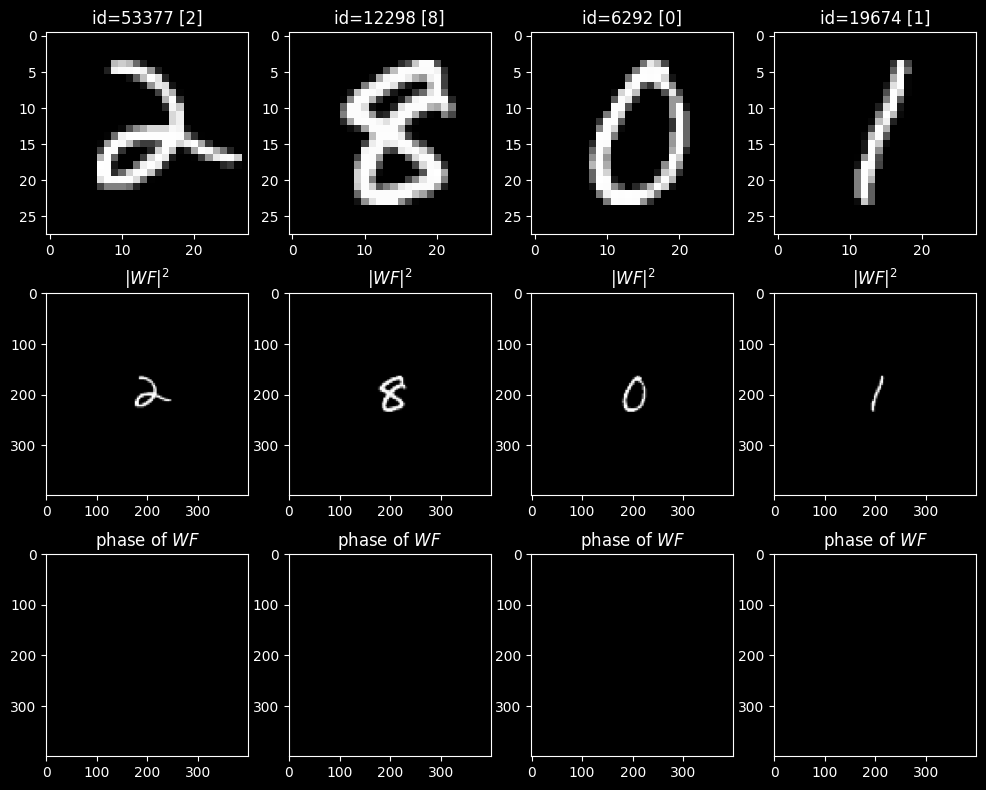

In [ ]:
# построим несколько примеров тренировочного датасета
n_examples= 4  # число примеров
# индексы изображений
random.seed(78)
train_examples_ids = random.sample(range(len(mnist_train_ds)), n_examples)

all_examples_wavefronts = []

n_lines = 3
fig, axs = plt.subplots(n_lines, n_examples, figsize=(n_examples * 3, n_lines * 3.2))
for ind_ex, ind_train in enumerate(train_examples_ids):
    image, label = mnist_train_ds[ind_train]
    
    axs[0][ind_ex].set_title(f'id={ind_train} [{label}]')
    axs[0][ind_ex].imshow(image, cmap='gray')

    wavefront, wf_label = mnist_wf_train_ds[ind_train]
    assert isinstance(wavefront, Wavefront)

    all_examples_wavefronts.append(wavefront)

    axs[1][ind_ex].set_title(f'$|WF|^2$')
    # интенсивность волновых фронтов
    axs[1][ind_ex].imshow(
        wavefront.intensity, cmap='gray',
        vmin=0, vmax=1
    )
    
    axs[2][ind_ex].set_title(f'phase of $WF$')
    axs[2][ind_ex].imshow(
        wavefront.phase, cmap='gray',
        vmin=0, vmax= 2 * torch.pi
    )

plt.show()

# 3. Оптическая сеть

Информация из дополнительного материала [[1]](https://www.science.org/doi/suppl/10.1126/science.aat8084/suppl_file/aat8084-lin-sm-rev-3.pdf) для классификации MNIST:

> Согласно соответствующей схеме $D^2NN$, аксиальное расстояние между двумя последовательными 3D-печатными слоями было установлено равным $3,0$ $см$...

> Расстояние между плоскостью детектора/выходной линзы и последним слоем оптической нейронной сети было установлено равным $3$ $см$...

#### <span style="color:red">Дополнительная информация</span>

Из [[2]](https://ieeexplore.ieee.org/abstract/document/8732486):

> ... аксиальное расстояние между последовательными дифракционными слоями установлено равным $\sim 40 \times \lambda$ как в [[1]](https://www.science.org/doi/10.1126/science.aat8084) ...

In [ ]:
NUM_OF_DIFF_LAYERS = 5  # число дифракционных слоев
FREE_SPACE_DISTANCE = 40 * working_wavelength  # [m] - расстояние между дифракционными слоями

In [35]:
print(f'Distance between layers is {FREE_SPACE_DISTANCE * 1e2:.3f} cm')

Distance between layers is 2.998 cm


## 3.1. Архитектура

См. рисунок 2А из [[1]](https://www.science.org/doi/10.1126/science.aat8084).

См. рисунок 1(а) из [[2]](https://ieeexplore.ieee.org/abstract/document/8732486).

### 3.1.1. Список элементов

In [ ]:
MAX_PHASE = 2 * np.pi  # максимальная фаза масок
MAX_TRANSMISSION = 1  # максимальный коэффициент пропускания (амплитуда каждого нейрона)

**<span style="color:red">Из [1,2]: </span>**
> a $5$-слойная, фазовая (комплекснозначная) дифракционная оптическая сеть ...

In [ ]:
PHASE_ONLY = True
# если True - мы не добавляем дополнительные обучаемые слои с апертурами (амплитудная модуляция)!

In [ ]:
FREESPACE_METHOD = 'AS'  # используется другой метод нежели в статье!!!

**<span style="color:red">Из [2]: </span>**
> дифракционный слой ... нейроны ... были инициализированы с $\pi$ для значений фазы и $1$ для значений амплитуды ...

In [ ]:
INIT_PHASES = torch.ones(NUM_OF_DIFF_LAYERS) * np.pi
INIT_TRANSMISSION = torch.ones(NUM_OF_DIFF_LAYERS) * 0.9  # в данном блокноте не используется

**<span style="color:red">Комментарий</span>**

Здесь мы используем `ConstrainedParameter` по умолчанию, который использует сигмоидальную функцию для ограничения диапазона параметров.

В [[2]](https://ieeexplore.ieee.org/abstract/document/8732486) авторы обсуждают такой подход в разделе «Результаты и обсуждение A» и подчеркивают, что ограничение параметров сигмоидальной функцией может привести к исчезающим градиентам. Авторы также предлагают другой способ ограничения параметров — с помощью ReLU.

В нашем случае сигмоидальная функция работает хорошо, но можно реализовать подход ReLU, указав `bound_func` для `ConstrainedParameter` (<span style="color:red">примеры настройки `bound_func` приведены в ...</span>).

In [ ]:
# функции, возвращающие отдельные элементы из архитектуры сети

def get_free_space(
    freespace_sim_params,
    freespace_distance,  # in [m]!
    freespace_method='AS',
):
    """
    возвращает слой FreeSpace с ограниченным параметром расстояния
    """
    return elements.FreeSpace(
        simulation_parameters=freespace_sim_params,
        distance=freespace_distance,  # distance is not learnable!
        method=freespace_method
    )


def get_const_transmission_layer(
    sim_params: SimulationParameters,
    value,  # must be from range [0, 1]
    max_transmission=1
):
    """
    возвращает апертуру Aperture с постоянной функцией пропускания.
    """
    x_nodes, y_nodes = sim_params.axes_size(axs=('W', 'H'))

    const_mask = torch.ones(size=(y_nodes, x_nodes)) * value
    
    return elements.Aperture(
        simulation_parameters=sim_params,
        mask=ConstrainedParameter(
            const_mask,
            min_value=0,
            max_value=max_transmission
        ),  # здесь используется ограниченный параметр!
    )


def get_const_phase_layer(
    sim_params: SimulationParameters,
    value, max_phase=2 * torch.pi
):
    """
    возвращает дифракционный слой DiffractiveLayer с постоянной фазовой маской.
    """
    x_nodes, y_nodes = sim_params.axes_size(axs=('W', 'H'))

    const_mask = torch.ones(size=(y_nodes, x_nodes)) * value
    
    return elements.DiffractiveLayer(
        simulation_parameters=sim_params,
        mask=ConstrainedParameter(
            const_mask,
            min_value=0,
            max_value=max_phase
        ),  # здесь используется ограниченный параметр!
    )  # см документацию!

Функция построения списка элементов для воспроизведения архитектуры из [расширенной статьи](https://ieeexplore.ieee.org/abstract/document/8732486):

In [ ]:
def get_elements_list(
    num_layers,
    simulation_parameters,
    freespace_method,
    transmission_values,
    phase_values,
    apertures=False,
    aperture_size=(100, 100)
):
    """
    Список элементов оптической схемы.
    ...

    Параметры
    ----------
    num_layers : int
        Число слоев в системе.
    simulation_parameters : SimulationParameters()
        Параметры моделирования.
    freespace_method : str
        Метод расчета распространения излучения.
    transmission_values : torch.Tensor()
        Torch tensor с коэффициентами пропускания для генерации постоянных масок
    phase_values : torch.Tensor()
        Torch tensor значений фазы для генерации постоянных масок для дифракционных слоев.
        
    apertures : bool
        If True, than before each DiffractiveLayer (and detector) we add a square aperture.
        Comment: there are strickt square apertures!
    aperture_size : tuple
        размер апертуры
        
    Returns
    -------
    elements_list : list(Element)
        Список элементов оптической схемы.
    """
    elements_list = []  # список элементов
    
    if apertures:  # одинаковые маски для всех апертур (выбирается центральная часть)
        aperture_mask = torch.ones(size=aperture_size)

        y_nodes, x_nodes = simulation_parameters.axes_size(axs=('H', 'W'))
        y_mask, x_mask = aperture_mask.size()
        pad_top = int((y_nodes - y_mask) / 2)
        pad_bottom = y_nodes - pad_top - y_mask
        pad_left = int((x_nodes - x_mask) / 2)
        pad_right = x_nodes - pad_left - x_mask  # params for transforms.Pad
        
        # преобразование заполнения для приведения в соответствие размера апертуры и параметров моделирования
        aperture_mask = functional.pad(
            input=aperture_mask,
            pad=(pad_left, pad_right, pad_top, pad_bottom),
            mode='constant',
            value=0
        )

    # первый слой FreeSpace перед первым DiffractiveLayer
    elements_list.append(
        get_free_space(
            simulation_parameters,  # параметры моделирования
            FREE_SPACE_DISTANCE,  # в [m]
            freespace_method=freespace_method,
        )
    )

    # архитектура
    for ind_layer in range(num_layers):

        # жесткая квадратная апертура Aperture
        if apertures:
            elements_list.append(
                elements.Aperture(
                    simulation_parameters=simulation_parameters,
                    mask=aperture_mask
                )
            )
            
        # -----------------------------------------------------------------------
        if not PHASE_ONLY:  # добавить обучаемую апертуру Aperture (обучаемые амплитуды в случае необходимости)
            elements_list.append(
                get_const_transmission_layer(
                    simulation_parameters,
                    value=transmission_values[ind_layer].item(),
                    max_transmission=MAX_TRANSMISSION
                )
            )
        
        # добавить DiffractiveLayer (обучаемая фазовая маска)
        elements_list.append(
            get_const_phase_layer(
                simulation_parameters,
                value=phase_values[ind_layer].item(),
                max_phase=MAX_PHASE
            )
        )
        # -----------------------------------------------------------------------
        
        # добавить FreeSpace
        elements_list.append(
            get_free_space(
                simulation_parameters,
                FREE_SPACE_DISTANCE,  # в [m]
                freespace_method=freespace_method,
            )
        )

    # ---------------------------------------------------------------------------
    # добавить жесткую квадратную апертуру Aperture перед Detector
    if apertures:
        elements_list.append(
            elements.Aperture(
                simulation_parameters=simulation_parameters,
                mask=aperture_mask
            )
        )
    
    # добавление Detector в конце системы!
    elements_list.append(
        Detector(
            simulation_parameters=simulation_parameters,
            func='intensity'  # детектор возвращает интенсивность
        )
    )

    return elements_list

In [42]:
architecture_elements_list = get_elements_list(
    num_layers=NUM_OF_DIFF_LAYERS,
    simulation_parameters=SIM_PARAMS,
    freespace_method=FREESPACE_METHOD,
    transmission_values=INIT_TRANSMISSION,
    phase_values=INIT_PHASES,
    apertures=True,
    aperture_size=DETECTOR_SIZE
)

print(f'Number of elements in the system (including Detector): {len(architecture_elements_list)}')

Number of elements in the system (including Detector): 18


### 3.1.2. Задание `LinearOpticalSetup`

In [ ]:
def get_setup(simulation_parameters):
    """
    возвращает оптическую схему. создает заново все элементы.
    """
    elements_list = get_elements_list(
        num_layers=NUM_OF_DIFF_LAYERS,
        simulation_parameters=SIM_PARAMS,
        freespace_method=FREESPACE_METHOD,
        transmission_values=INIT_TRANSMISSION,
        phase_values=INIT_PHASES,
        apertures=True,
        aperture_size=DETECTOR_SIZE
    )  # recreate a list of elements

    return LinearOpticalSetup(elements=elements_list)

In [ ]:
# создание оптической схемы
optical_setup = get_setup(SIM_PARAMS)

In [45]:
optical_setup.net

Sequential(
  (0): FreeSpace()
  (1): Aperture()
  (2): DiffractiveLayer(
    (mask_svtlnn_inner_parameter): InnerParameterStorageModule()
  )
  (3): FreeSpace()
  (4): Aperture()
  (5): DiffractiveLayer(
    (mask_svtlnn_inner_parameter): InnerParameterStorageModule()
  )
  (6): FreeSpace()
  (7): Aperture()
  (8): DiffractiveLayer(
    (mask_svtlnn_inner_parameter): InnerParameterStorageModule()
  )
  (9): FreeSpace()
  (10): Aperture()
  (11): DiffractiveLayer(
    (mask_svtlnn_inner_parameter): InnerParameterStorageModule()
  )
  (12): FreeSpace()
  (13): Aperture()
  (14): DiffractiveLayer(
    (mask_svtlnn_inner_parameter): InnerParameterStorageModule()
  )
  (15): FreeSpace()
  (16): Aperture()
  (17): Detector()
)

**<span style="color:red">Комментарий:</span>** Схема заканчивается элементом `Detector` который возвращает выходной тензор интенсивностей для каждого входного `Wavefront`.

#### Пример расчета распространения волнового фронта

In [46]:
example_wf = mnist_wf_train_ds[128][0]

In [47]:
mnist_wf_train_ds[128][1]

1

In [48]:
setup_scheme, wavefronts = optical_setup.stepwise_forward(example_wf)

-(0)-> [1. FreeSpace] -(1)-> [2. Aperture] -(2)-> [3. DiffractiveLayer] -(3)-> [4. FreeSpace] -(4)-> [5. Aperture] -(5)-> [6. DiffractiveLayer] -(6)-> [7. FreeSpace] -(7)-> [8. Aperture] -(8)-> [9. DiffractiveLayer] -(9)-> [10. FreeSpace] -(10)-> [11. Aperture] -(11)-> [12. DiffractiveLayer] -(12)-> [13. FreeSpace] -(13)-> [14. Aperture] -(14)-> [15. DiffractiveLayer] -(15)-> [16. FreeSpace] -(16)-> [17. Aperture] -(17)-> [18. Detector] -(18)->


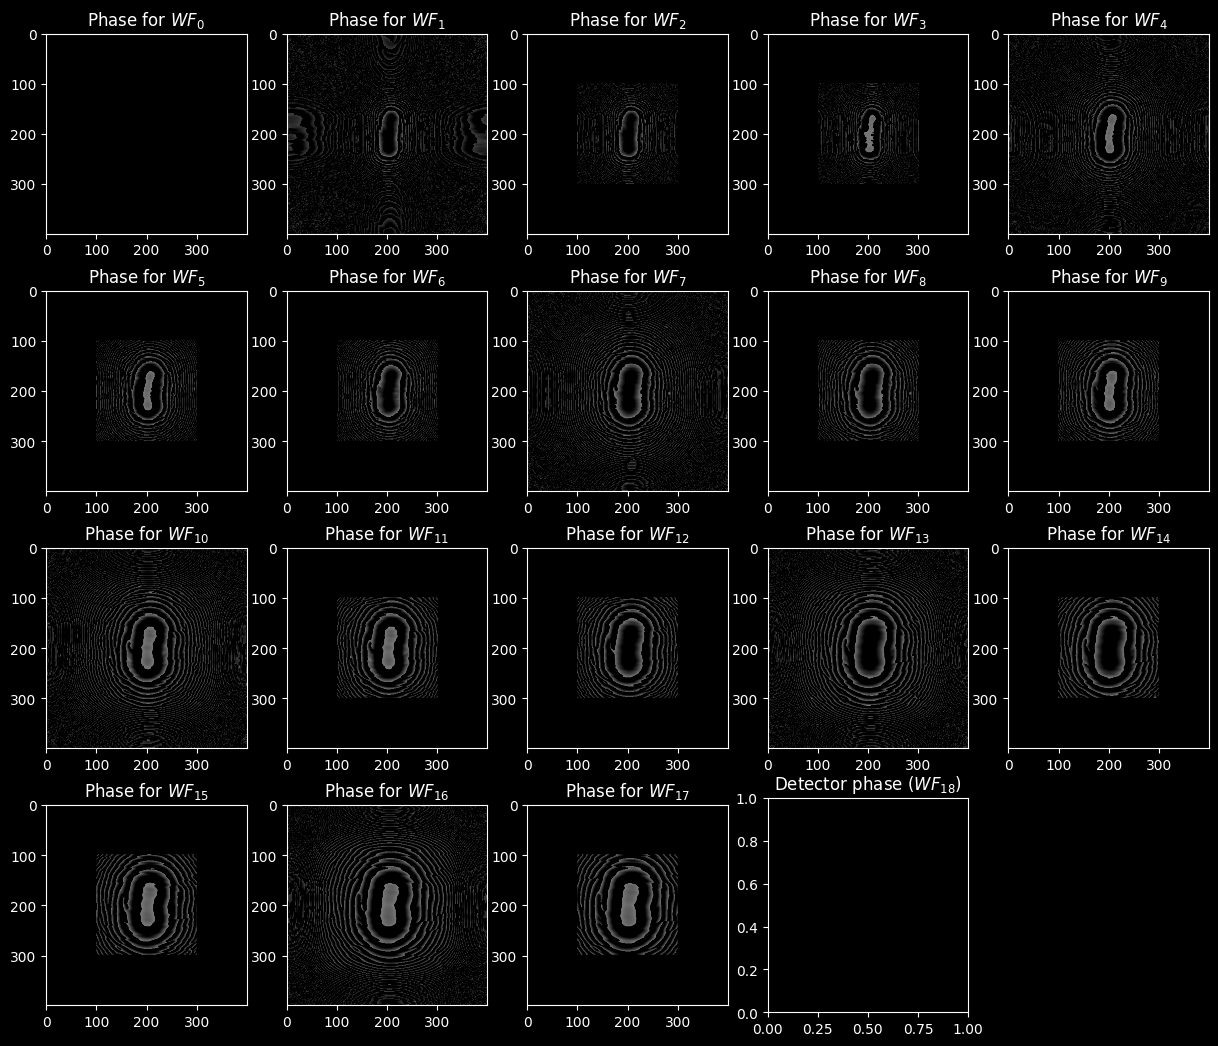

In [ ]:
print(setup_scheme)  # печать схемы

n_cols = 5  # число столбцов для постронения всех волновых фронтов при распространении
n_rows = (len(optical_setup.net) // n_cols) + 1

to_plot = 'phase'  # <--- что строим
cmap = 'grey'  # цветовая схема
detector_cmap = 'hot'

# create a figure with subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 3.2))

# убираем ненужные оси
for ind_row in range(n_rows):
    for ind_col in range(n_cols):
        ax_this = axs[ind_row][ind_col]
        if ind_row * n_cols + ind_col >= len(wavefronts):
            ax_this.axis('off')

# построение волновых фронтов
for ind_wf, wavefront in enumerate(wavefronts):
    ax_this = axs[ind_wf // n_cols][ind_wf % n_cols]

    if to_plot == 'phase':
        # построение фазы, поскольку картины интенсивности неразличимы
        if ind_wf < len(wavefronts) - 1:
            ax_this.set_title('Phase for $WF_{' + f'{ind_wf}' + '}$')
            ax_this.imshow(
                wavefront.phase.detach().numpy(), cmap=cmap,
                vmin=0, vmax=2 * torch.pi
            )
        else:  # (не волновой фронт!)
            ax_this.set_title('Detector phase ($WF_{' + f'{ind_wf}' + '})$')
            # на детекторе нет фазы!

    if to_plot == 'amp':
        # построение фазы, поскольку картины интенсивности неразличимы
        if ind_wf < len(wavefronts) - 1:
            ax_this.set_title('Intensity for $WF_{' + f'{ind_wf}' + '}$')
            ax_this.imshow(
                wavefront.intensity.detach().numpy(), cmap=cmap,
                # vmin=0, vmax=max_intensity  # разкомментировать, чтобы сделать пределы одинаковыми
            )
        else:  #  выход Detector (не волновой фронт!)
            ax_this.set_title('Detector Intensity ($WF_{' + f'{ind_wf}' + '})$')
            ax_this.imshow(
                wavefront.detach().numpy(), cmap=detector_cmap,
                # vmin=0, vmax=max_intensity  # разкомментировать, чтобы сделать пределы одинаковыми
            )

    # Комментарий: выход детектора - Tensor! У него нет методов Wavefront (фаза или интенсивность)!

plt.show()

### 3.1.3 Обработчик детектора (Detector processor) (для расчета точности)

> ... размеры детекторов $(6.4 \lambda \times 6.4 \lambda)$ ...

**<span style="color:red">Комментарий:</span>** `DetectorProcessor` в нашей библиотеке используется для обработки информации на детекторе. Например, для текущей задачи `DetectorProcessor` должен вернуть только 10 значений (по одному значению на 1 класс).

In [50]:
import src.detector_segmentation as detector_segmentation

In [51]:
number_of_classes = 10

#### Маска детектора

In [52]:
detector_segment_size = 6.4 * working_wavelength

In [ ]:
# размер каждого сегмента в нейронах
x_segment_nodes = int(detector_segment_size / neuron_size)
y_segment_nodes = int(detector_segment_size / neuron_size)
# размер = (y_segment_nodes, x_segment_nodes)

In [54]:
y_boundary_nodes = y_segment_nodes * 9
x_boundary_nodes = x_segment_nodes * 9

#### Маска детектора

In [ ]:
detector_squares_mask = detector_segmentation.squares_mnist(
    y_boundary_nodes, x_boundary_nodes,  # размер детектора или апертуры (в центре детектора)
    SIM_PARAMS
)

#### Detector processor

В [[2]](https://ieeexplore.ieee.org/abstract/document/8732486) авторы предлагают использовать CrossEntropyLoss. Для этого предлагается рассчитать следующие значения для каждого выходного сигнала:

> ... измеренные интенсивности D-детекторов в выходной плоскости нормализуются таким образом, чтобы они лежали в интервале $(0,10)$ для каждого отсчёта. Если $I_l$ обозначает полный оптический сигнал, падающий на $l^\text{th}$-детектор в выходной плоскости, то нормализованные интенсивности $I_l^\prime$ можно найти по формуле:
$$ I_l^\prime = \frac{I_l}{\max \left\{ I_l \right\} } \times 10.$$

**<span style="color:red">Комментарий:</span>** Здесь необходимо указать прямую функцию для пакета изображений для последующего процессора детекторов. Согласно предложению авторов, приведенному выше, наш процессор детектора должен возвращать 10 значений.

In [ ]:
class DetectorProcessorOzcanClf(DetectorProcessorClf):
    """
    переопределим метод прямого распространения в DetectorProcessorCls чтобы воспроизвести процесс обучения из работы [2].
    """
    
    def batch_forward(self, batch_detector_data: torch.Tensor) -> torch.Tensor:
        """
        Вычисляет вероятности принадлежности классам для батча изображений детектора.
        ...

        Параметры
        ----------
        batch_detector_data : torch.Tensor
            Батч изображений с детектора.
            shape=(batch_size, ... 'H', 'W').

        Returns
        -------
        torch.Tensor
            Тензор вероятностей элемента принадлежать классам для последующего расчета функции потерь.
            shape=(batch_size, self.num_classes)
        """
        batch_size = batch_detector_data.size()[0]  # batch size is a 0'th dimension!

        integrals_by_classes = torch.zeros(size=(batch_size, self.num_classes)).to(self._DetectorProcessorClf__device)
        for ind_class in range(self.num_classes):
            integrals_by_classes[:, ind_class] = (
                    self.batch_zone_integral(batch_detector_data, ind_class)
            )

        return integrals_by_classes / torch.unsqueeze(torch.max(integrals_by_classes, dim=1)[0], 1) * 10

In [ ]:
# создать объект DetectorProcessorOzcanClf
detector_processor = DetectorProcessorOzcanClf(
    simulation_parameters=SIM_PARAMS,
    num_classes=number_of_classes,
    segmented_detector=detector_squares_mask,
)

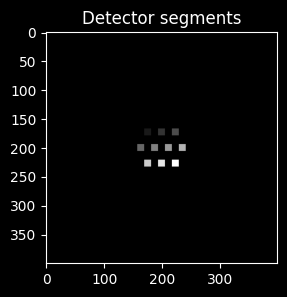

In [58]:
fig, ax0 = plt.subplots(1, 1, figsize=(3, 3))

ax0.set_title(f'Detector segments')
ax0.imshow(detector_processor.segmented_detector, cmap='grey')

plt.show()

#### Визуализация зон детектора

In [59]:
ZONES_HIGHLIGHT_COLOR = 'w'
ZONES_LW = 0.5
selected_detector_mask = detector_processor.segmented_detector.clone().detach()

In [ ]:
def get_zones_patches(detector_mask):
    """
    Возвращает список патчей для отрисовки зон в итоговой визуализации
    """
    zones_patches = []

    delta = 0.5
    
    for ind_class in range(number_of_classes):
        idx_y, idx_x = (detector_mask == ind_class).nonzero(as_tuple=True)
        
        zone_rect = patches.Rectangle(
            (idx_x[0] - delta, idx_y[0] - delta), 
            idx_x[-1] - idx_x[0] + 2 * delta, idx_y[-1] - idx_y[0] + 2 * delta, 
            linewidth=ZONES_LW, 
            edgecolor=ZONES_HIGHLIGHT_COLOR,
            facecolor='none'
        )
        
        zones_patches.append(zone_rect)

    return zones_patches

# 4. Обучение сети

Текущие переменные
- `lin_optical_setup` : `LinearOpticalSetup` – линейная оптическая сеть, составленная из Elements
- `detector_processor` : `DetectorProcessorClf` – этот слой обрабатывает изображение с детектора и выичисляет вероятности принадлежности классам.

In [ ]:
DEVICE = 'cpu'  # 'mps' не поддерживает CrossEntropyLoss

In [62]:
# DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

DEVICE

'cpu'

## 4.1. Подготовка к тренировке

### 4.1.1. `DataLoader`

Информация из дополнительного материала [[1]](https://www.science.org/doi/suppl/10.1126/science.aat8084/suppl_file/aat8084-lin-sm-rev-3.pdf) по классификации MNIST:

> Размер обучающей партии был установлен в размере $8$...

In [ ]:
train_bs = 8  # размер батча для тренировочного набора
val_bs = 20

> Для этой задачи были разработаны маски пропускания только фазы путем обучения пятислойной нейронной сети $D^2$ с $55000$ изображениями ($5000$ проверочными изображениями) из базы данных рукописных цифр MNIST (Модифицированный Национальный институт стандартов и технологий).

In [ ]:
# mnist_wf_train_ds
train_wf_ds, val_wf_ds = torch.utils.data.random_split(
    dataset=mnist_wf_train_ds,
    lengths=[55000, 5000],  # размеры из статьи
    generator=torch.Generator().manual_seed(178)  # для воспроизводимости
)

In [65]:
train_wf_loader = torch.utils.data.DataLoader(
    train_wf_ds,
    batch_size=train_bs,
    shuffle=True,
    # num_workers=2,
    drop_last=False,
)

val_wf_loader = torch.utils.data.DataLoader(
    val_wf_ds,
    batch_size=val_bs,
    shuffle=False,
    # num_workers=2,
    drop_last=False,
)

### 4.1.2. Оптимизатор и функция потерь

Информация из дополнительного материала [[1]](https://www.science.org/doi/suppl/10.1126/science.aat8084/suppl_file/aat8084-lin-sm-rev-3.pdf) для классификации MNIST:

> Мы использовали алгоритм стохастического градиентного спуска Adam для обратного распространения ошибок и обновления
слоёв сети для минимизации функции потерь.

**<span style="color:red">Дополнительная информация</span>** из [[2]](https://ieeexplore.ieee.org/abstract/document/8732486):
> метод обратного распространения с применением адаптивного оптимизатора (Adam) со скоростью обучения $10^{−3}$

In [66]:
LR = 1e-3

In [67]:
def get_adam_optimizer(net):
    return torch.optim.Adam(
        params=net.parameters(),  # NETWORK PARAMETERS!
        lr=LR
    )

In [68]:
loss_func_clf = nn.CrossEntropyLoss()
loss_func_name = 'CE loss'

### 4.1.3. Циклы обучения и оценки

In [69]:
from src.clf_loops import onn_train_clf, onn_validate_clf

## 4.2. Обучение оптической нейронной сети

### 4.2.1. До обучения

> дифракционный слой ... нейроны ... были инициализированы с $\pi$ для значений фазы и $1$ для значений амплитуды ...

#### Метрики для тестового датасета

In [ ]:
test_wf_loader = torch.utils.data.DataLoader(
    mnist_wf_test_ds,
    batch_size=10,
    shuffle=False,
    # num_workers=2,
    drop_last=False,
)  # загрузчик данных для MNIST

In [71]:
# lin_optical_setup.net = lin_optical_setup.net.to(DEVICE)
# SIM_PARAMS = SIM_PARAMS.to(DEVICE)

In [ ]:
test_losses_0, _, test_accuracy_0 = onn_validate_clf(
    optical_setup.net,  # оптическая сеть из раздела 3.
    test_wf_loader,  # dataloader для тренирововчного датасета
    detector_processor,  # обработчик детектора
    loss_func_clf,
    device=DEVICE,
    show_process=True,
)  # оценка модели

print(
    'Results before training on TEST set:\n' + 
    f'\t{loss_func_name} : {np.mean(test_losses_0):.6f}\n' +
    f'\tAccuracy : {(test_accuracy_0*100):>0.1f} %'
)

validation: 100%|████████████████████████████████████████████████████████████████████████| 1000/1000 [05:01<00:00,  3.32it/s]

Results before training on TEST set:
	CE loss : 5.788926
	Accuracy : 13.0 %


### 4.2.2. Обучение

In [ ]:
n_epochs = 20
print_each = 2  # печатать информацию каждую print_each эпоху

In [ ]:
scheduler = None  # планировщик для настройки LR во время обучения

In [ ]:
# Воссоздайте систему для возобновления обучения!
ozcan_optical_setup = get_setup(SIM_PARAMS)

# оптимизатор для воссозданной сети!
optimizer_clf = get_adam_optimizer(ozcan_optical_setup.net)

In [76]:
# lin_optical_setup.net = lin_optical_setup.net.to(DEVICE)

In [77]:
train_epochs_losses = []
val_epochs_losses = []  # to store losses of each epoch

train_epochs_acc = []
val_epochs_acc = []  # to store accuracies

torch.manual_seed(98)  # for reproducability?

for epoch in range(n_epochs):
    if (epoch == 0) or ((epoch + 1) % print_each == 0) or (epoch == n_epochs - 1):
        print(f'Epoch #{epoch + 1}: ', end='')
        show_progress = True
    else:
        show_progress = False

    # TRAIN
    start_train_time = time.time()  # start time of the epoch (train)
    train_losses, _, train_accuracy = onn_train_clf(
        ozcan_optical_setup.net,  # optical network composed in 3.
        train_wf_loader,  # dataloader of training set
        detector_processor,  # detector processor
        loss_func_clf,
        optimizer_clf,
        device=DEVICE,
        show_process=show_progress,
    )  # train the model
    mean_train_loss = np.mean(train_losses)
    
    if (epoch == 0) or ((epoch + 1) % print_each == 0) or (epoch == n_epochs - 1):  # train info
        print('Training results')
        print(f'\t{loss_func_name} : {mean_train_loss:.6f}')
        print(f'\tAccuracy : {(train_accuracy*100):>0.1f} %')
        print(f'\t------------   {time.time() - start_train_time:.2f} s')

    # VALIDATION
    start_val_time = time.time()  # start time of the epoch (validation)
    val_losses, _, val_accuracy = onn_validate_clf(
        ozcan_optical_setup.net,  # optical network composed in 3.
        val_wf_loader,  # dataloader of validation set
        detector_processor,  # detector processor
        loss_func_clf,
        device=DEVICE,
        show_process=show_progress,
    )  # evaluate the model
    mean_val_loss = np.mean(val_losses)
    
    if (epoch == 0) or ((epoch + 1) % print_each == 0) or (epoch == n_epochs - 1):  # validation info
        print('Validation results')
        print(f'\t{loss_func_name} : {mean_val_loss:.6f}')
        print(f'\tAccuracy : {(val_accuracy*100):>0.1f} %')
        print(f'\t------------   {time.time() - start_val_time:.2f} s')
            
    if scheduler:
        scheduler.step(mean_val_loss) 

    # save losses
    train_epochs_losses.append(mean_train_loss)
    val_epochs_losses.append(mean_val_loss)
    # seve accuracies
    train_epochs_acc.append(train_accuracy)
    val_epochs_acc.append(val_accuracy)

Epoch #1: 

train: 100%|█████████████████████████████████████████████████████████████████████████████| 6875/6875 [34:33<00:00,  3.32it/s]


Training results
	CE loss : 0.607821
	Accuracy : 83.9 %
	------------   2073.56 s


validation: 100%|██████████████████████████████████████████████████████████████████████████| 250/250 [01:44<00:00,  2.39it/s]


Validation results
	CE loss : 0.221047
	Accuracy : 93.9 %
	------------   104.46 s
Epoch #2: 

train: 100%|█████████████████████████████████████████████████████████████████████████████| 6875/6875 [36:19<00:00,  3.15it/s]


Training results
	CE loss : 0.176673
	Accuracy : 95.1 %
	------------   2179.58 s


validation: 100%|██████████████████████████████████████████████████████████████████████████| 250/250 [01:40<00:00,  2.49it/s]


Validation results
	CE loss : 0.154740
	Accuracy : 95.8 %
	------------   100.20 s
Epoch #4: 

train: 100%|█████████████████████████████████████████████████████████████████████████████| 6875/6875 [24:42<00:00,  4.64it/s]


Training results
	CE loss : 0.106353
	Accuracy : 97.3 %
	------------   1482.87 s


validation: 100%|██████████████████████████████████████████████████████████████████████████| 250/250 [01:09<00:00,  3.58it/s]


Validation results
	CE loss : 0.119395
	Accuracy : 96.8 %
	------------   69.75 s
Epoch #6: 

train: 100%|█████████████████████████████████████████████████████████████████████████████| 6875/6875 [24:28<00:00,  4.68it/s]


Training results
	CE loss : 0.083325
	Accuracy : 98.1 %
	------------   1468.50 s


validation: 100%|██████████████████████████████████████████████████████████████████████████| 250/250 [01:08<00:00,  3.65it/s]


Validation results
	CE loss : 0.109656
	Accuracy : 97.1 %
	------------   68.58 s
Epoch #8: 

train: 100%|█████████████████████████████████████████████████████████████████████████████| 6875/6875 [24:20<00:00,  4.71it/s]


Training results
	CE loss : 0.070422
	Accuracy : 98.5 %
	------------   1460.35 s


validation: 100%|██████████████████████████████████████████████████████████████████████████| 250/250 [01:08<00:00,  3.66it/s]


Validation results
	CE loss : 0.101900
	Accuracy : 97.4 %
	------------   68.39 s
Epoch #10: 

train: 100%|█████████████████████████████████████████████████████████████████████████████| 6875/6875 [24:22<00:00,  4.70it/s]


Training results
	CE loss : 0.062464
	Accuracy : 98.8 %
	------------   1462.06 s


validation: 100%|██████████████████████████████████████████████████████████████████████████| 250/250 [01:08<00:00,  3.66it/s]


Validation results
	CE loss : 0.100767
	Accuracy : 97.3 %
	------------   68.35 s
Epoch #12: 

train: 100%|█████████████████████████████████████████████████████████████████████████████| 6875/6875 [24:21<00:00,  4.71it/s]


Training results
	CE loss : 0.056382
	Accuracy : 99.0 %
	------------   1461.01 s


validation: 100%|██████████████████████████████████████████████████████████████████████████| 250/250 [01:08<00:00,  3.66it/s]


Validation results
	CE loss : 0.100092
	Accuracy : 97.5 %
	------------   68.33 s
Epoch #14: 

train: 100%|█████████████████████████████████████████████████████████████████████████████| 6875/6875 [24:21<00:00,  4.70it/s]


Training results
	CE loss : 0.051384
	Accuracy : 99.2 %
	------------   1461.45 s


validation: 100%|██████████████████████████████████████████████████████████████████████████| 250/250 [01:08<00:00,  3.64it/s]


Validation results
	CE loss : 0.101520
	Accuracy : 97.2 %
	------------   68.66 s
Epoch #16: 

train: 100%|█████████████████████████████████████████████████████████████████████████████| 6875/6875 [24:22<00:00,  4.70it/s]


Training results
	CE loss : 0.047399
	Accuracy : 99.3 %
	------------   1462.80 s


validation: 100%|██████████████████████████████████████████████████████████████████████████| 250/250 [01:08<00:00,  3.64it/s]


Validation results
	CE loss : 0.100677
	Accuracy : 97.2 %
	------------   68.65 s
Epoch #18: 

train: 100%|█████████████████████████████████████████████████████████████████████████████| 6875/6875 [24:24<00:00,  4.69it/s]


Training results
	CE loss : 0.044716
	Accuracy : 99.4 %
	------------   1464.82 s


validation: 100%|██████████████████████████████████████████████████████████████████████████| 250/250 [01:09<00:00,  3.62it/s]


Validation results
	CE loss : 0.100320
	Accuracy : 97.1 %
	------------   69.13 s
Epoch #20: 

train: 100%|█████████████████████████████████████████████████████████████████████████████| 6875/6875 [24:26<00:00,  4.69it/s]


Training results
	CE loss : 0.041933
	Accuracy : 99.5 %
	------------   1466.25 s


validation: 100%|██████████████████████████████████████████████████████████████████████████| 250/250 [01:08<00:00,  3.63it/s]

Validation results
	CE loss : 0.098532
	Accuracy : 97.1 %
	------------   68.90 s


#### Кривые обучения (CrossEntropyLoss и Accuracy)

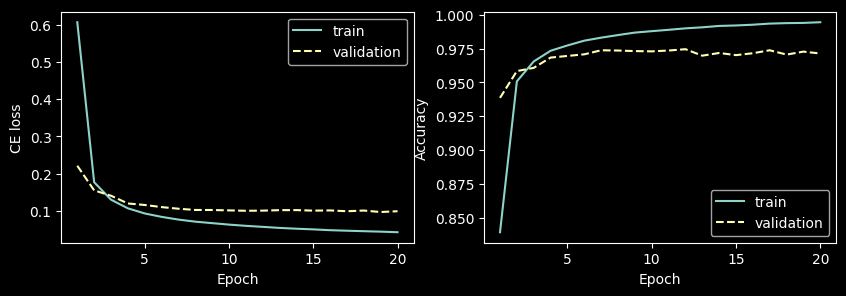

In [78]:
# learning curve
fig, axs = plt.subplots(1, 2, figsize=(10, 3))

axs[0].plot(range(1, n_epochs + 1), train_epochs_losses, label='train')
axs[0].plot(range(1, n_epochs + 1), val_epochs_losses, linestyle='dashed', label='validation')

axs[1].plot(range(1, n_epochs + 1), train_epochs_acc, label='train')
axs[1].plot(range(1, n_epochs + 1), val_epochs_acc, linestyle='dashed', label='validation')

axs[0].set_ylabel(loss_func_name)
axs[0].set_xlabel('Epoch')
axs[0].legend()

axs[1].set_ylabel('Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].legend()

plt.show()

In [79]:
# array with all losses
# TODO: make with PANDAS?
all_lasses_header = ','.join([
    f'{loss_func_name.split()[0]}_train', f'{loss_func_name.split()[0]}_val',
    'accuracy_train', 'accuracy_val'
])
all_losses_array = np.array(
    [train_epochs_losses, val_epochs_losses, train_epochs_acc, val_epochs_acc]
).T

#### Обученные фазовые маски

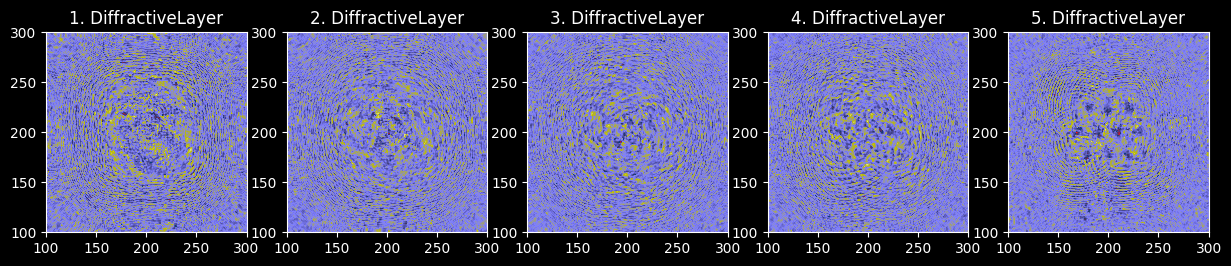

In [80]:
n_cols = NUM_OF_DIFF_LAYERS  # number of columns for DiffractiveLayer's masks visualization
n_rows = 1

# plot wavefronts phase
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 3.2))
ind_diff_layer = 0

cmap = 'gist_stern'  # 'gist_stern' 'rainbow'

for ind_layer, layer in enumerate(ozcan_optical_setup.net):
    if isinstance(layer, elements.DiffractiveLayer):  # plot masks for Diffractive layers
        if n_rows > 1:
            ax_this = axs[ind_diff_layer // n_cols][ind_diff_layer % n_cols]
        else:
            ax_this = axs[ind_diff_layer % n_cols]

        ax_this.set_title(f'{ind_diff_layer + 1}. DiffractiveLayer')

        trained_mask = layer.mask.detach()
        
        ax_this.imshow(         
            trained_mask, cmap=cmap,
            vmin=0, vmax=MAX_PHASE
        )
        ind_diff_layer += 1

    # select only a part within apertures!
    x_frame = (x_layer_nodes - DETECTOR_SIZE[1]) / 2
    y_frame = (y_layer_nodes - DETECTOR_SIZE[0]) / 2
    ax_this.set_xlim([x_frame, x_layer_nodes - x_frame])
    ax_this.set_ylim([y_frame, y_layer_nodes - y_frame])

plt.show()

### 4.2.3. Сохранение результатов

#### Пути

In [81]:
RESULTS_FOLDER = 'models/reproduced_results/MNIST_Ozcan_2018-2020'

if not os.path.exists(RESULTS_FOLDER):
    os.makedirs(RESULTS_FOLDER)

In [82]:
# filepath to save the model
model_filepath = f'{RESULTS_FOLDER}/optical_setup_net.pth'
# filepath to save losses
losses_filepath = f'{RESULTS_FOLDER}/training_curves.csv'

#### Сохранение весов модели и кривых обучения

In [83]:
# saving model
# torch.save(ozcan_optical_setup.net.state_dict(), model_filepath)

In [84]:
# saving losses
# np.savetxt(
#     losses_filepath, all_losses_array,
#     delimiter=',', header=all_lasses_header, comments=""
# )

# 5. Загрузка сохраненных весов модели

In [85]:
RESULTS_FOLDER = 'models/reproduced_results/MNIST_Ozcan_2018-2020'

load_model_filepath = f'{RESULTS_FOLDER}/optical_setup_net.pth'

In [86]:
# setup to load weights
ozcan_optical_setup_loaded = get_setup(SIM_PARAMS)

# LOAD WEIGHTS
ozcan_optical_setup_loaded.net.load_state_dict(torch.load(load_model_filepath))

/var/folders/mt/0w6nmsr119bb2g4h4xrv9p6m0000gn/T/ipykernel_2610/484346891.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ozcan_optical_setup_loaded.net.load_state_dict(

<All keys matched successfully>

## 5.1. Расчет метрик на тестовом наборе загруженной модели

Проверьте, что загруженная модель работает корректно!

In [87]:
test_losses_1, _, test_accuracy_1 = onn_validate_clf(
    ozcan_optical_setup_loaded.net,  # optical network with loaded weights
    test_wf_loader,  # dataloader of training set
    detector_processor,  # detector processor
    loss_func_clf,
    device=DEVICE,
    show_process=True,
)  # evaluate the model

print(
    'Results after training on TEST set:\n' + 
    f'\t{loss_func_name} : {np.mean(test_losses_1):.6f}\n' +
    f'\tAccuracy : {(test_accuracy_1 * 100):>0.1f} %'
)

validation: 100%|████████████████████████████████████████████████████████████████████████| 1000/1000 [02:00<00:00,  8.33it/s]

Results after training on TEST set:
	CE loss : 0.090103
	Accuracy : 97.4 %


## 5.2. Пример классификации (распространение через сеть)

### 5.2.1. Выбор тестового изображения

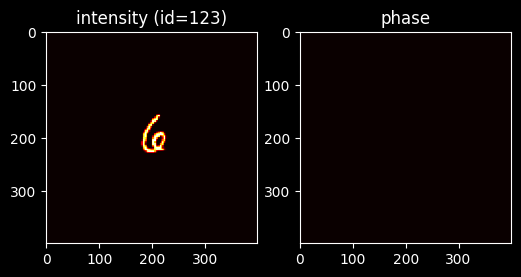

In [90]:
# plot an image
# '1' - 3214, good
# '4' - 6152, good
# '6' - 123, good
# '8' - 128, good
# '0' - 3, good
ind_test = 123
cmap = 'hot'

fig, axs = plt.subplots(1, 2, figsize=(2 * 3, 3))

test_wavefront, test_target = mnist_wf_test_ds[ind_test]

axs[0].set_title(f'intensity (id={ind_test})')
axs[0].imshow(test_wavefront.intensity, cmap=cmap)

axs[1].set_title(f'phase')
axs[1].imshow(
    test_wavefront.phase, cmap=cmap,
    vmin=0, vmax=2 * torch.pi
)

plt.show()

In [91]:
# propagation of the example through the trained network
setup_scheme, test_wavefronts = ozcan_optical_setup_loaded.stepwise_forward(test_wavefront)

### 5.2.2. Амплитудные профили

-(0)-> [1. FreeSpace] -(1)-> [2. Aperture] -(2)-> [3. DiffractiveLayer] -(3)-> [4. FreeSpace] -(4)-> [5. Aperture] -(5)-> [6. DiffractiveLayer] -(6)-> [7. FreeSpace] -(7)-> [8. Aperture] -(8)-> [9. DiffractiveLayer] -(9)-> [10. FreeSpace] -(10)-> [11. Aperture] -(11)-> [12. DiffractiveLayer] -(12)-> [13. FreeSpace] -(13)-> [14. Aperture] -(14)-> [15. DiffractiveLayer] -(15)-> [16. FreeSpace] -(16)-> [17. Aperture] -(17)-> [18. Detector] -(18)->


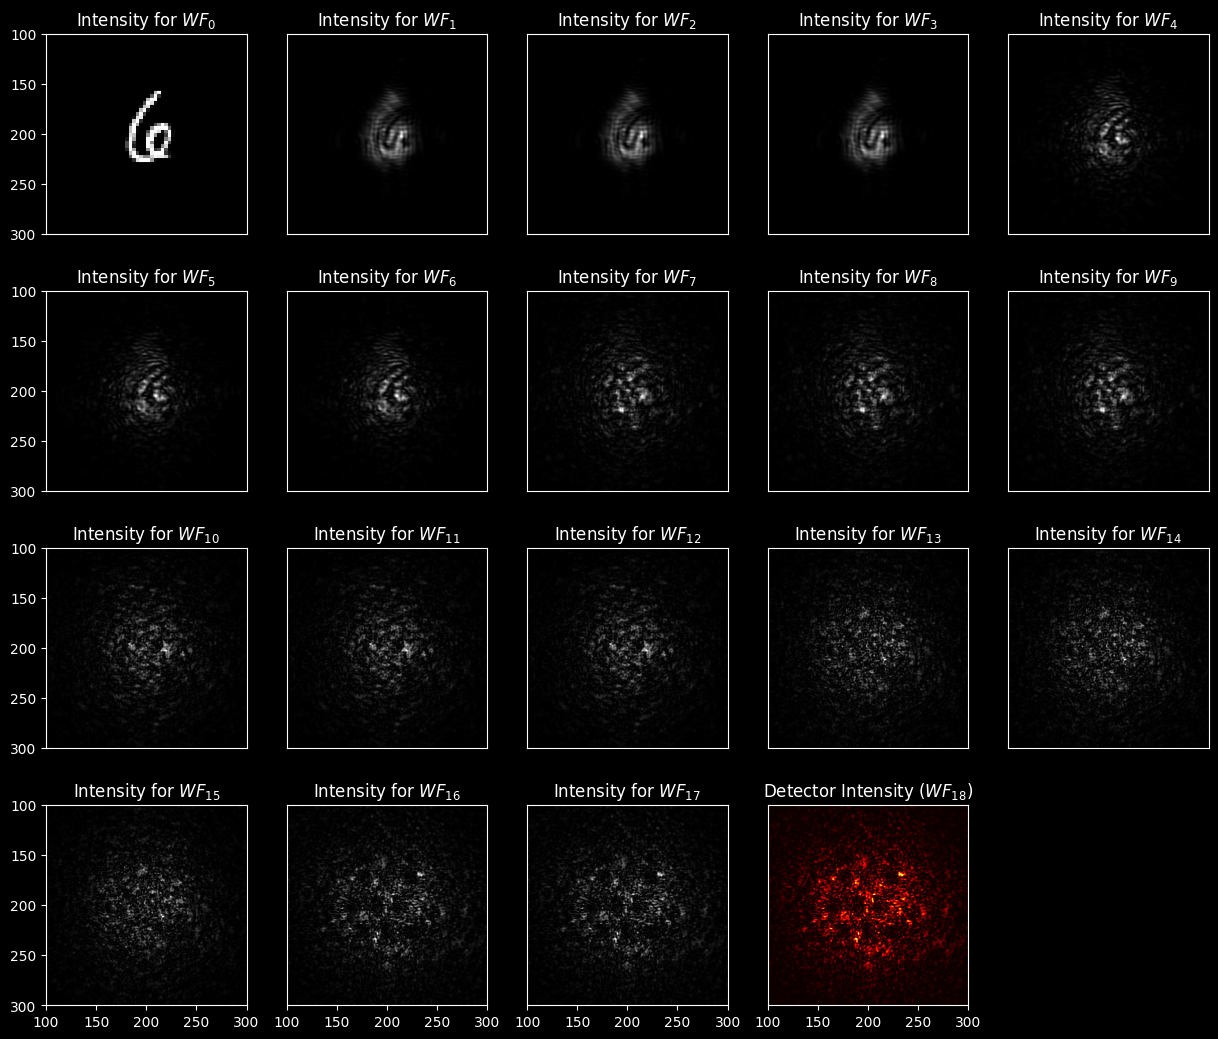

In [92]:
print(setup_scheme)  # prints propagation scheme

n_cols = 5  # number of columns to plot all wavefronts during propagation
n_rows = (len(ozcan_optical_setup_loaded.net) // n_cols) + 1

to_plot = 'amp'  # <--- chose what to plot
cmap = 'grey'  # choose colormaps
detector_cmap = 'hot'

within_aperture = True  # if true plots only the field which is within apertures!

# create a figure with subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 3.2))

# turn off unecessary axes
for ind_row in range(n_rows):
    for ind_col in range(n_cols):
        ax_this = axs[ind_row][ind_col]
        if ind_row * n_cols + ind_col >= len(test_wavefronts):
            ax_this.axis('off')

# plot wavefronts
for ind_wf, wavefront in enumerate(test_wavefronts):
    ax_this = axs[ind_wf // n_cols][ind_wf % n_cols]

    # delete unnecessary ticks
    if not (ind_wf // n_cols) == n_rows - 1:
        ax_this.set_xticks([])
    if not (ind_wf % n_cols) == 0:
        ax_this.set_yticks([])
    
    if to_plot == 'phase':
        # plot angle for each wavefront, because intensities pictures are indistinguishable from each other
        if ind_wf < len(wavefronts) - 1:
            ax_this.set_title('Phase for $WF_{' + f'{ind_wf}' + '}$')
            ax_this.imshow(
                wavefront.phase.detach().numpy(), cmap=cmap,
                vmin=0, vmax=2 * torch.pi
            )
        else:  # (not a wavefront!)
            ax_this.set_title('Detector phase ($WF_{' + f'{ind_wf}' + '})$')
            # Detector has no phase!

    if to_plot == 'amp':
        # plot angle for each wavefront, because intensities pictures are indistinguishable from each other
        if ind_wf < len(test_wavefronts) - 1:
            ax_this.set_title('Intensity for $WF_{' + f'{ind_wf}' + '}$')
            ax_this.imshow(
                wavefront.intensity.detach().numpy(), cmap=cmap,
                # vmin=0, vmax=max_intensity  # uncomment to make the same limits
            )
        else:  # Detector output (not a wavefront!)
            ax_this.set_title('Detector Intensity ($WF_{' + f'{ind_wf}' + '})$')
            ax_this.imshow(
                wavefront.detach().numpy(), cmap=detector_cmap,
                # vmin=0, vmax=max_intensity  # uncomment to make the same limits
            )
            
    # Comment: Detector output is Tensor! It has no methods of Wavefront (like .phase or .intensity)!
    if within_aperture:
        # select only a part within apertures!
        x_frame = (x_layer_nodes - DETECTOR_SIZE[1]) / 2
        y_frame = (y_layer_nodes - DETECTOR_SIZE[0]) / 2
        ax_this.axis([x_frame, x_layer_nodes - x_frame, y_layer_nodes - y_frame, y_frame])

plt.show()

### 5.2.3. Изображение на детекторе

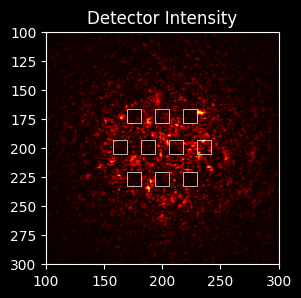

In [93]:
# create a figure with subplots
fig, ax_this = plt.subplots(1, 1, figsize=(3, 3.2))

# Detector output (not a wavefront!)
ax_this.set_title('Detector Intensity')
ax_this.imshow(
    test_wavefronts[-1].detach().numpy(), cmap='hot',
    # vmin=0, vmax=1  # uncomment to make the same limits
)

for zone in get_zones_patches(detector_squares_mask):
    # add zone's patches to the axis
    # zone_copy = copy(zone)
    ax_this.add_patch(zone)

# select only a part within apertures!
x_frame = (x_layer_nodes - DETECTOR_SIZE[1]) / 2
y_frame = (y_layer_nodes - DETECTOR_SIZE[0]) / 2
plt.axis([x_frame, x_layer_nodes - x_frame, y_layer_nodes - y_frame, y_frame])

plt.show()

In [94]:
# get probabilities of an example classification
test_probas = detector_processor.forward(test_wavefronts[-1])
# Comment: forward() method is from DetectorProcessorClf
#          p_i = I(detector_i) / sum_j(I(detector_j))
# Comment: It's another output than for batch_forward, that was used during training!

assert np.isclose(test_probas.sum().item(), 1)

for label, prob in enumerate(test_probas[0]):
    print(f'{label} : {prob * 100:.2f}%')

0 : 7.39%
1 : 12.80%
2 : 5.50%
3 : 8.10%
4 : 8.00%
5 : 10.72%
6 : 30.72%
7 : 5.40%
8 : 6.53%
9 : 4.85%


## 5.3._Эффективность_

### 5.3.1. Предсказать все тестовые наборы данных и сохранить все результаты

In [96]:
targets_test_lst = []
preds_test_lst = []

detector_sums_by_classes = [
    torch.zeros(size=SIM_PARAMS.axes_size(axs=('H', 'W'))) for _ in range(number_of_classes)
]
samples_by_classes = [0 for _ in range(number_of_classes)]
probas_sums_by_classes = [
    torch.zeros(number_of_classes) for _ in range(number_of_classes)
]

# loop over the test dataset
for ind, (wavefront_this, target_this) in enumerate(tqdm(mnist_wf_test_ds)):
    ozcan_optical_setup_loaded.net.eval()
    
    batch_wavefronts = torch.unsqueeze(wavefront_this, 0)
    batch_labels = torch.unsqueeze(torch.tensor(target_this), 0)  # to use forwards for batches
    
    with torch.no_grad():
        detector_output = ozcan_optical_setup_loaded.net(batch_wavefronts)
        # process a detector image
        batch_probas = detector_processor.batch_forward(detector_output)

        for ind_in_batch in range(batch_labels.size()[0]):
            label_this = batch_labels[ind_in_batch].item()  # true label
            targets_test_lst.append(label_this)
            
            detector_sums_by_classes[label_this] += detector_output[ind_in_batch]
            probas_sums_by_classes[label_this] += batch_probas[ind_in_batch]
            samples_by_classes[label_this] += 1

            preds_test_lst.append(batch_probas[ind_in_batch].argmax().item())

100%|██████████████████████████████████████████████████████████████████████████████████| 10000/10000 [05:46<00:00, 28.84it/s]


### 5.3.2. Матрица ошибок

In [97]:
for class_ind in range(number_of_classes):
    probas_sums_by_classes[class_ind] /= samples_by_classes[class_ind]

In [98]:
avg_probas_mat = torch.zeros(size=(number_of_classes, number_of_classes))

for ind_class in range(number_of_classes):
    avg_probas_mat[ind_class, :] = probas_sums_by_classes[ind_class]

In [99]:
# ordinary confusion matrix
confusion_matrix = torch.zeros(size=(number_of_classes, number_of_classes), dtype=torch.int32)

for ind in range(len(mnist_wf_test_ds)):
    confusion_matrix[targets_test_lst[ind], preds_test_lst[ind]] += 1

#### Построение матрицы ошибок

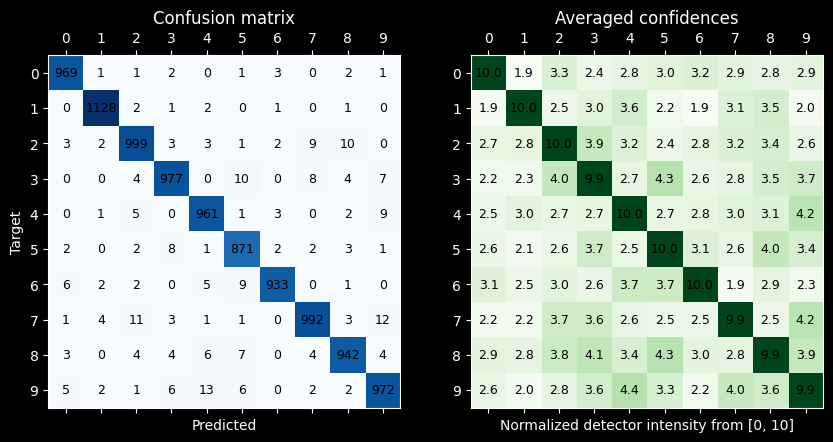

In [101]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5))

# CONFUSION MATRIX
ax0.set_title('Confusion matrix')
ax0.matshow(confusion_matrix, cmap='Blues')

for i in range(number_of_classes):
    for j in range(number_of_classes):
        val = confusion_matrix[j, i].item()
        ax0.text(
            i, j, str(val),
            va='center', ha='center', 
            c='k', fontsize=9
        )

ax0.set_ylabel('Target')
ax0.set_xlabel('Predicted')

ax0.set_xticks(range(number_of_classes))
ax0.set_yticks(range(number_of_classes))

# AVERAGED PREDICTED PROBAS
ax1.set_title('Averaged confidences')
ax1.matshow(avg_probas_mat, cmap='Greens')

for i in range(number_of_classes):
    for j in range(number_of_classes):
        val = avg_probas_mat[j, i].item()
        ax1.text(
            i, j, f'{val:.1f}',
            va='center', ha='center', 
            c='k', fontsize=9
        )

ax1.set_xlabel('Normalized detector intensity from [0, 10]')

ax1.set_xticks(range(number_of_classes))
ax1.set_yticks(range(number_of_classes))
# ax1.set_yticks(range(number_of_classes), labels=['' for _ in range(number_of_classes)])

plt.show()

# save figure
# fig.savefig(f'{RESULTS_FOLDER}/confusion_matrix.png', bbox_inches='tight')

### 5.3.3. Усредненный детектор для выбранного класса

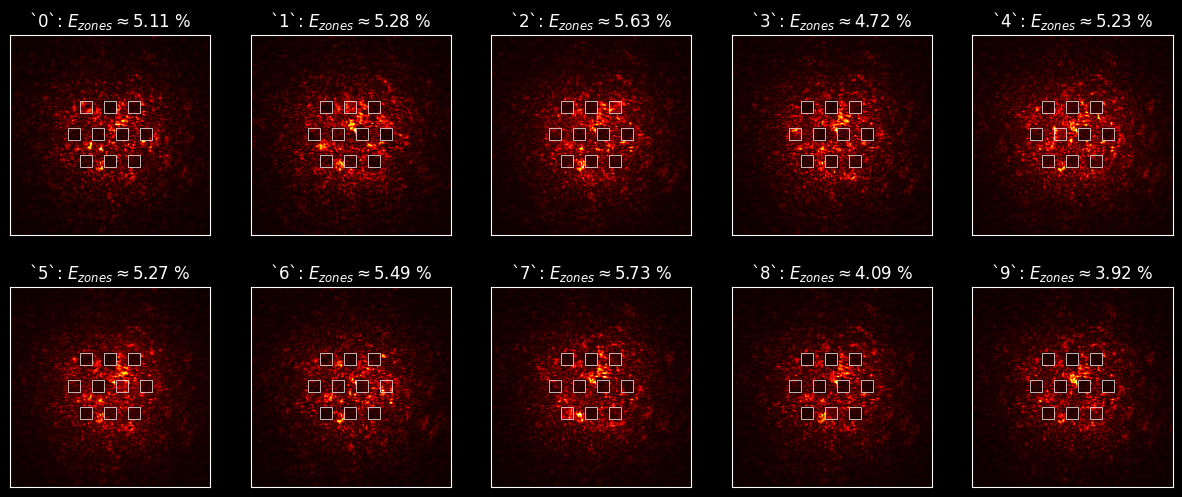

In [103]:
n_cols = 5  # number of columns to plot all wavefronts during propagation
n_rows = (number_of_classes // n_cols)

detector_cmap = 'hot'

# create a figure with subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 3))

# turn off unecessary axes
for ind_row in range(n_rows):
    for ind_col in range(n_cols):
        ax_this = axs[ind_row][ind_col]
        if ind_row * n_cols + ind_col >= number_of_classes:
            ax_this.axis('off')

# plot wavefronts
for selected_class in range(number_of_classes):
    ax_this = axs[selected_class // n_cols][selected_class % n_cols]

    # focus "efficiency"
    int_over_detector_zones = 0
    
    for ind_class in range(number_of_classes):
        int_over_detector_zones += detector_processor.batch_zone_integral(
            detector_sums_by_classes[selected_class].unsqueeze(0).unsqueeze(0),
            ind_class=ind_class,
        )[0].item()

    detector_int = detector_sums_by_classes[selected_class].sum().item()
    detector_efficiency = int_over_detector_zones / detector_int
    
    # Detector output (not a wavefront!)
    ax_this.set_title(
        f'`{selected_class}`: ' + r'$E_{zones}\approx$' + 
        f'{detector_efficiency * 100:.2f} %'
    )
    ax_this.imshow(
        detector_sums_by_classes[selected_class] / samples_by_classes[selected_class],
        cmap=detector_cmap,
        # vmin=0, vmax=0.02  # uncomment to make the same limits
    )
    
    for zone in get_zones_patches(selected_detector_mask):
        # add zone's patches to the axis
        # zone_copy = copy(zone)
        ax_this.add_patch(zone)

    ax_this.set_xticks([])
    ax_this.set_yticks([])

    # select only a part within apertures!
    x_frame = (x_layer_nodes - DETECTOR_SIZE[1]) / 2
    y_frame = (y_layer_nodes - DETECTOR_SIZE[0]) / 2
    ax_this.axis([x_frame, x_layer_nodes - x_frame, y_layer_nodes - y_frame, y_frame])

plt.show()

# save figure
# fig.savefig(f'{RESULTS_FOLDER}/averaged_detector_for_classes.png', bbox_inches='tight')

### 5.6.3. _Эффективность_ детектора

$$
\frac{\sum\limits_{\text{class}=0}^9 \left( \iint\limits_{S_\text{class}} I(x,y) \right)}{\iint\limits_{S_\text{detector}} I(x,y)}
$$

In [104]:
detector_efficiency_by_classes = {}

for selected_class in range(number_of_classes):
    int_over_detector_zones = 0
    
    for ind_class in range(number_of_classes):
        int_over_detector_zones += detector_processor.batch_zone_integral(
            detector_sums_by_classes[selected_class].unsqueeze(0).unsqueeze(0),
            ind_class=ind_class,
        )[0].item()

    detector_int = detector_sums_by_classes[selected_class].sum().item()
    detector_efficiency_by_classes[selected_class] = int_over_detector_zones / detector_int

In [105]:
detector_efficiency_by_classes

{0: 0.051086358630961295,
 1: 0.05275452364851289,
 2: 0.056273571915820046,
 3: 0.04719619080707646,
 4: 0.052285331494994515,
 5: 0.05266327137292357,
 6: 0.054925868638560915,
 7: 0.057319602716312715,
 8: 0.04086047440142262,
 9: 0.03918716269950237}